In [1]:
# Data management and investigation
import pandas as pd
import numpy as np
import missingno as msno
from plotnine import *
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

from functools import reduce

In [5]:
# import 2019 reliability, net metering, energy efficiency, advanced metering infrastructure, demand response, and service territory data
reliability_19 = pd.read_excel("raw_data/Reliability_2019.xlsx", 
                               header = 1)
net_metering_19 = pd.read_excel("raw_data/Net_Metering_2019.xlsx", 
                                header = [0,1,2])
efficiency_19 = pd.read_excel("raw_data/Energy_Efficiency_2019.xlsx", 
                              header = [0,1,2])
demand_response_19 = pd.read_excel("raw_data/Demand_Response_2019.xlsx", 
                              header = [0,1,2])
territory_19 = pd.read_excel("raw_data/Service_Territory_2019.xlsx")
utility_19 = pd.read_excel("raw_data/Sales_Ult_Cust_2019.xlsx", 
                                header = [0,1,2])
circuits_19 = pd.read_excel("raw_data/Distribution_Systems_2019.xlsx")
op_19 = pd.read_excel("raw_data/Operational_Data_2019.xlsx", 
                                header = [0,1,2])

In [6]:
# Combine the headers together to describe each column
net_metering_19.columns = net_metering_19.columns.map(' - '.join)
efficiency_19.columns = efficiency_19.columns.map(' - '.join)
demand_response_19.columns = demand_response_19.columns.map(' - '.join)
utility_19.columns = utility_19.columns.map(' - '.join)
op_19.columns = op_19.columns.map(' - '.join)

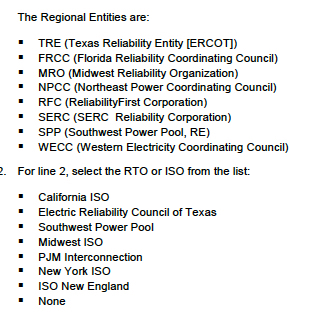

In [7]:
# only grab the columns I want from each dataframe
reliability_19 = reliability_19[['Utility Number',
              'Utility Name', 
              'State', # control
              'Ownership', # control 
              'SAIDI Without MED',
              'SAIFI Without MED', 
              'CAIDI Without MED']].dropna()

In [8]:
reliability_19.columns = ['no', 'name', 'state','type','saidi_nomed', 'saifi_nomed', 'caidi_nomed']

In [9]:
op_19 = op_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
              'Utility Characteristics - Unnamed: 6_level_1 - NERC Region', 
              'Utility Characteristics - Unnamed: 4_level_1 - State',
              'Energy Sources (Megawatthours) - Unnamed: 9_level_1 - Net Generation',
              'Energy Sources (Megawatthours) - Unnamed: 10_level_1 - Wholesale Power Purchases' 
              ]].dropna()

In [10]:
op_19.columns = ['name','nerc','state','gen_mwh','purchase_mwh']

In [11]:
net_metering_19 = net_metering_19[['Utility Characteristics - Unnamed: 3_level_1 - Utility Name',
                                   'Utility Characteristics - Unnamed: 1_level_1 - State',
                                   'Utility Characteristics - Unnamed: 5_level_1 - BA Code',
                'Photovoltaic - Energy Sold Back MWh - Total',
                'Wind - Energy Sold Back MWh - Total',
                'All Technologies - Energy Sold Back MWh - Total',
                ]].dropna()

In [12]:
net_metering_19.columns = ['name', 'state', 'ba','pv_mwh', 'wind_mwh', 'nm_mwh']

In [13]:
efficiency_19 = efficiency_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
                               'Utility Characteristics - Unnamed: 4_level_1 - State',
                  'Reporting Year Incremental Annual Savings - Energy Savings (MWh) - Total']].dropna()

In [14]:
efficiency_19.columns = ['name','state','ee_mwh']

In [15]:
demand_response_19 = demand_response_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
                                         'Utility Characteristics - Unnamed: 4_level_1 - State',
                    'Yearly Energy and Demand Savings - Number of Customers Enrolled - Total',
                    'Yearly Energy and Demand Savings - Energy Savings (MWh) - Total']].dropna()

In [16]:
demand_response_19.columns = ['name', 'state','dem_res_customers', 'dem_res_mwh']

In [17]:
territory_19 = territory_19[['Utility Name',
             'State',
             'County']]

In [18]:
territory_19.columns = ['name', 'state', 'county']

In [19]:
utility_19 = utility_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
                         'Utility Characteristics - Unnamed: 6_level_1 - State',
                         'TOTAL - Sales - Megawatthours',
                         'TOTAL - Customers - Count']]

In [20]:
utility_19.columns = ['name', 'state','total_mwh','total_cust']

In [21]:
circuits_19 = circuits_19[['Utility Name',
                           'State',
                           'Distribution Circuits',
                         'Circuits with Voltage Optimization']]

In [22]:
circuits_19.columns = ['name', 'state','circuits', 'voltage']

In [23]:
# merge all the lists together by utility name 
df_list = [utility_19, reliability_19, circuits_19, op_19, net_metering_19, efficiency_19, demand_response_19]
df_19 = reduce(lambda left,right: pd.merge(left,right,on=['name','state'], how='outer'), df_list)

In [24]:
# drop the duplicate rows 
df_19 = df_19[~df_19.duplicated(['name', 'state'])]

In [25]:
# drop all the entries where my outcome variable is not present (SAIDI, SAIFI and CAIDI are same – I checked)
df_19 = df_19[~df_19.saidi_nomed.isna()]

In [26]:
# remove those missing total customer data and total megawatthours (5 rows)
df_19 = df_19[~df_19.total_mwh.isna()]
df_19 = df_19[~df_19.total_cust.isna()]

In [27]:
df_19.isna().sum(axis=0)

name                   0
state                  0
total_mwh              0
total_cust             0
no                     0
type                   0
saidi_nomed            0
saifi_nomed            0
caidi_nomed            0
circuits               0
voltage                0
nerc                 112
gen_mwh              112
purchase_mwh         112
ba                   316
pv_mwh               316
wind_mwh             316
nm_mwh               316
ee_mwh               740
dem_res_customers    858
dem_res_mwh          858
dtype: int64

In [28]:
# fill na's with 0 
# i assume that if they didn't fill it out, there is nothing to report
df_19 = df_19.fillna(0).reset_index(drop=True)

In [29]:
df_19.shape

(1179, 21)

### Try alternative method where I don't fillna

In [30]:
df_19_nona = df_19.copy()

In [31]:
df_19_nona.isna().sum(axis=0)

name                 0
state                0
total_mwh            0
total_cust           0
no                   0
type                 0
saidi_nomed          0
saifi_nomed          0
caidi_nomed          0
circuits             0
voltage              0
nerc                 0
gen_mwh              0
purchase_mwh         0
ba                   0
pv_mwh               0
wind_mwh             0
nm_mwh               0
ee_mwh               0
dem_res_customers    0
dem_res_mwh          0
dtype: int64

In [32]:
df_19_nona = df_19_nona.dropna(axis=0, subset = ['gen_mwh','dem_res_customers','ee_mwh','pv_mwh'])

In [33]:
df_19_nona

,name,state,total_mwh,total_cust,no,type,saidi_nomed,saifi_nomed,caidi_nomed,circuits,...,nerc,gen_mwh,purchase_mwh,ba,pv_mwh,wind_mwh,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh
0,A & N Electric Coop,MD,2623.0,316.0,84.0,Cooperative,.,.,.,1.0,...,0,0.0,0.0,0,0.000,0.000,0.000,0.00,35.0,1.05
1,A & N Electric Coop,VA,701387.0,35618.0,84.0,Cooperative,.,.,.,43.0,...,RFC,596.0,743457.0,PJM,0.000,0.000,0.000,0.00,2101.0,63.03
2,Adams Electric Coop,IL,176102.0,8931.0,97.0,Cooperative,169.74,1.29,131.581,47.0,...,SERC,4612.0,183534.0,MISO,0.000,0.000,0.000,0.00,4402.0,0.00
3,Adams-Columbia Electric Coop,WI,515186.0,37607.0,108.0,Cooperative,139.9,0.95,147.263,95.0,...,MRO,0.0,545904.0,MISO,705.775,22.235,728.010,0.00,4781.0,13647.36
4,Agralite Electric Coop,MN,238558.0,5251.0,155.0,Cooperative,128.759,1.181,109.025,64.0,...,MRO,447.0,253275.0,MISO,0.000,0.000,0.000,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,City of Winter Park - (FL),FL,425022.0,15565.0,58124.0,Municipal,.,.,.,16.0,...,FRCC,0.0,445668.0,FPC,401.337,0.000,401.337,15.18,0.0,0.00
1175,PUD No 1 of Jefferson County,WA,376212.0,19742.0,59013.0,Political Subdivision,291,2.04,142.647,21.0,...,0,0.0,0.0,BPAT,0.000,0.000,0.000,651.00,0.0,0.00
1176,CKenergy Electric Cooperative,OK,654238.0,25684.0,60482.0,Cooperative,.,.,.,95.0,...,0,0.0,0.0,SWPP,0.000,0.000,0.000,0.00,457.0,9.60
1177,Upper Michigan Energy Resources Corp.,MI,1610240.0,36818.0,60631.0,Investor Owned,238,1.5,158.667,57.0,...,0,0.0,0.0,MISO,0.000,0.000,0.000,0.00,80.0,0.00


In [34]:
df_19_nona.dtypes

name                  object
state                 object
total_mwh            float64
total_cust           float64
no                   float64
type                  object
saidi_nomed           object
saifi_nomed           object
caidi_nomed           object
circuits             float64
voltage              float64
nerc                  object
gen_mwh              float64
purchase_mwh         float64
ba                    object
pv_mwh               float64
wind_mwh             float64
nm_mwh               float64
ee_mwh               float64
dem_res_customers    float64
dem_res_mwh          float64
dtype: object

In [35]:
df_19_nona['pv_pct'] = ((df_19_nona['pv_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [36]:
df_19['wind_pct'] = ((df_19_nona['wind_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [37]:
df_19_nona['nm_pct'] = ((df_19_nona['nm_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [38]:
df_19_nona['ee_pct'] = ((df_19_nona['ee_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [39]:
df_19_nona['dem_res_pct'] = ((df_19_nona['dem_res_mwh']/df_19_nona['total_mwh']) * 100).fillna(0)

In [40]:
df_19_nona['dem_res_cust_pct'] = ((df_19_nona['dem_res_customers']/df_19_nona['total_cust']) * 100).fillna(0)

In [41]:
df_19_nona = df_19_nona[(df_19_nona.saidi_nomed != '.')].reset_index(drop=True)

In [42]:
# export as CSV so I can use it in my next step
df_19_nona.to_csv("df_19_nona.csv",index=False)

### Final check for accuracy

In [120]:
df_19.sample(6)

,name,state,total_mwh,total_cust,no,type,saidi_nomed,saifi_nomed,caidi_nomed,circuits,...,nerc,gen_mwh,purchase_mwh,ba,pv_mwh,wind_mwh,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh
411,"HILCO Electric Cooperative, Inc.",TX,591343.0,29380.0,8620.0,Cooperative,72.202,0.911,79.2558,44.0,...,TRE,0.0,626620.0,ERCO,0.0,0.0,0.0,152.510,0.0,0.0
1102,Wisconsin Power & Light Co,WI,11017009.0,475545.0,20856.0,Investor Owned,.,.,.,1160.0,...,MRO,9927167.0,4090139.0,MISO,0.0,0.0,0.0,0.000,126.0,186.0
757,Pacific Gas & Electric Co.,CA,36462157.0,2635291.0,14328.0,Investor Owned,134.1,0.995,134.774,3109.0,...,WECC,33491087.0,42164686.0,CISO,0.0,0.0,0.0,1322045.000,268381.0,3963.0
82,"Bowie-Cass Electric Coop, Inc",TX,642083.0,37907.0,2049.0,Cooperative,.,.,.,110.0,...,SPP,0.0,691495.0,SWPP,0.0,0.0,0.0,0.000,0.0,0.0
1072,Village of Waunakee - (WI),WI,118605.0,6531.0,20211.0,Municipal,80.63,0.54,149.315,16.0,...,MISO,0.0,122440.0,MISO,0.0,0.0,0.0,0.000,0.0,0.0
1089,City of Westfield - (MA),MA,353536.0,18061.0,20481.0,Municipal,80.332,1.713,46.8955,14.0,...,NPCC,0.0,359788.0,0,0.0,0.0,0.0,3297.428,0.0,0.0


Here, I did a check on a random sample of 6 observations across categories to make sure everything looked good. When there's a NA for any of the reliability metrics, that means that data was missing from the survey, and I cannot simply impute with 0's – that would incorrectly be assuming that they had no system interruptions. My best option is to simply drop these rows, since they lack my outcome variable.

### Make the percentage net metering, energy efficiency, and demand response columns. 

In [43]:
df_19['pv_pct'] = ((df_19['pv_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [44]:
df_19['wind_pct'] = ((df_19['wind_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [45]:
df_19['nm_pct'] = ((df_19['nm_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [46]:
df_19['ee_pct'] = ((df_19['ee_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [47]:
df_19['dem_res_pct'] = ((df_19['dem_res_mwh']/df_19['total_mwh']) * 100).fillna(0)

In [48]:
df_19['dem_res_cust_pct'] = ((df_19['dem_res_customers']/df_19['total_cust']) * 100).fillna(0)

### Need to justify using SAIDI rather than SAIFI or CAIDI

There are 766 entries for SAIDI, and only about 705 for SAIFI and CAIDI. Therefore, I will be using SAIDI as my index for grid reliability.

In [49]:
# check non zero entries
#df_19[(df_19.saifi_nomed != '.')]

In [50]:
# limit dataframe to SAIDI, which has the most nonzero entries 
df_19 = df_19[(df_19.saidi_nomed != '.')].reset_index(drop=True)

In [51]:
df_19.describe()

,total_mwh,total_cust,no,circuits,voltage,gen_mwh,purchase_mwh,pv_mwh,wind_mwh,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh,wind_pct,pv_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
count,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,7.670000e+02,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,2.877815e+06,1.325098e+05,12300.241199,190.542373,47.014342,1.603899e+06,1.562233e+06,1549.682040,85.946874,1643.192293,2.754904e+04,12274.062581,1751.307789,0.002523,0.063293,0.066940,0.368537,0.018130,4.560795
std,8.153767e+06,3.853289e+05,8559.434421,475.750289,205.103511,8.019806e+06,4.091160e+06,18568.046351,1827.784027,20219.445852,1.255740e+05,69746.807005,35827.024220,0.029555,0.496231,0.512219,1.061427,0.179930,13.820391
min,2.829000e+03,4.100000e+01,97.000000,1.000000,0.000000,-5.120000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.374375e+05,1.095350e+04,5896.000000,30.000000,0.000000,0.000000e+00,1.591930e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.314040e+05,2.415200e+04,12268.000000,57.000000,0.000000,0.000000e+00,4.425630e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.484748e+06,6.527150e+04,16715.000000,123.000000,19.000000,4.650000e+01,1.078380e+06,55.925500,0.000000,65.226500,1.209000e+03,31.500000,0.000000,0.000000,0.007547,0.008335,0.237313,0.000000,0.035619
max,1.119557e+08,5.061483e+06,60839.000000,5619.000000,2787.000000,1.265085e+08,5.667982e+07,466156.237000,49255.057000,515411.294000,2.097423e+06,895133.000000,977215.000000,0.758238,10.630452,10.630452,10.727103,3.509534,100.000000


In [52]:
#df_19 = df_19.drop(['pv_mwh',
#            'wind_mwh',
#            'nm_mwh',
#            'ee_mwh',
#            'dem_res_customers',
#            'dem_res_mwh'], axis = 1)

In [53]:
df_19.sort_values(by='name')

,name,state,total_mwh,total_cust,no,type,saidi_nomed,saifi_nomed,caidi_nomed,circuits,...,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh,wind_pct,pv_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
220,4-County Electric Power Assn,MS,1090317.0,48915.0,6641.0,Cooperative,125.82,1.47,85.5918,89.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
400,"ALLETE, Inc.",MN,9014805.0,147340.0,12647.0,Investor Owned,144.02,1.35,106.681,369.0,...,577.929,61243.0,7897.0,746.00,0.000059,0.006352,0.006411,0.679360,0.008275,5.359712
0,Adams Electric Coop,IL,176102.0,8931.0,97.0,Cooperative,169.74,1.29,131.581,47.0,...,0.000,0.0,4402.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,49.288993
1,Adams-Columbia Electric Coop,WI,515186.0,37607.0,108.0,Cooperative,139.9,0.95,147.263,95.0,...,728.010,0.0,4781.0,13647.36,0.004316,0.136994,0.141310,0.000000,2.649016,12.713059
2,Agralite Electric Coop,MN,238558.0,5251.0,155.0,Cooperative,128.759,1.181,109.025,64.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,Wyrulec Company,WY,171783.0,4822.0,21079.0,Cooperative,164.019,1.128,145.407,37.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
720,Wyrulec Company,NE,18771.0,499.0,21079.0,Cooperative,353.521,2.228,158.672,8.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
719,Y-W Electric Assn Inc,CO,335317.0,8783.0,21075.0,Cooperative,62.7,.,.,89.0,...,2.523,112.7,0.0,0.00,0.000000,0.000752,0.000752,0.033610,0.000000,0.000000
722,Yampa Valley Electric Assn Inc,CO,552803.0,27065.0,21081.0,Cooperative,203.5,2.421,84.0562,123.0,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

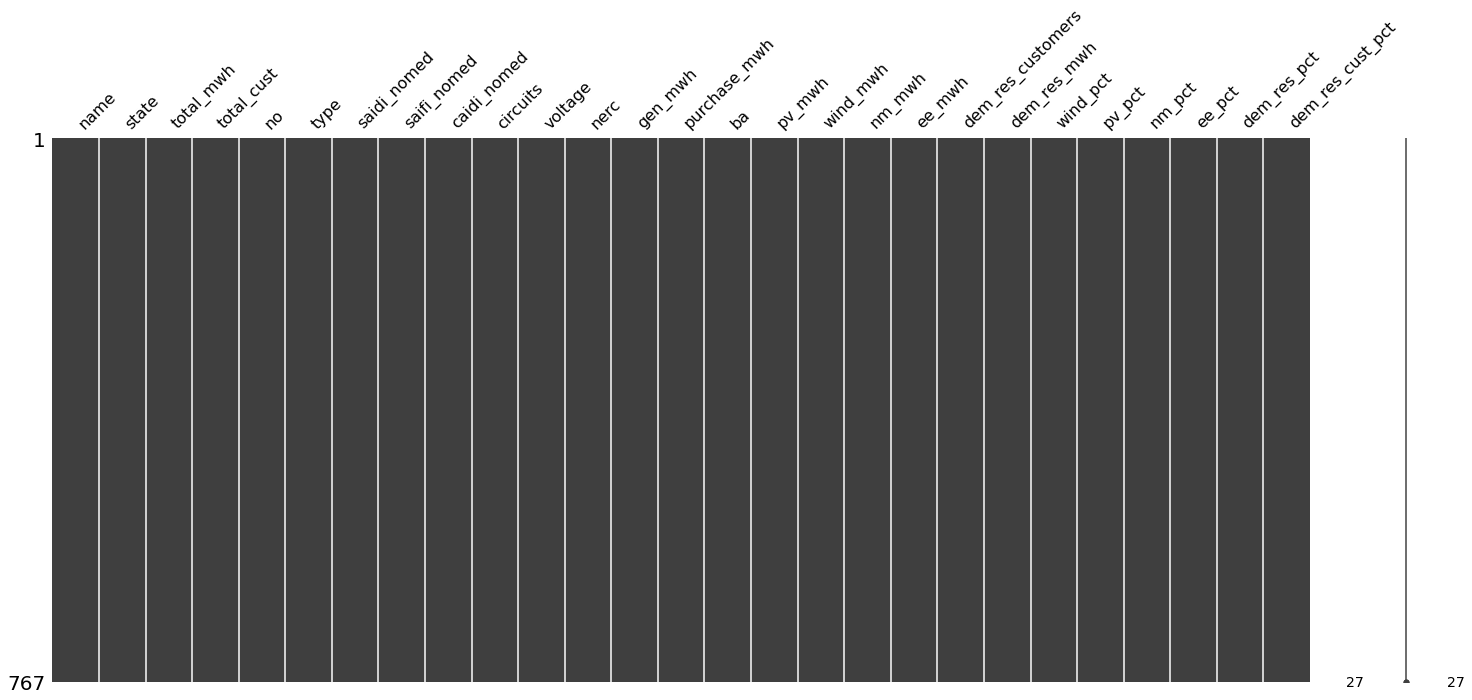

In [54]:
# make sure we're good to go
msno.matrix(df_19)

In [55]:
# export as CSV so I can use it in my next step
df_19.to_csv("processed_data/df_19.csv",index=False)

## Unresolved pile

In [ ]:
# when we mergeed our dataframes, they dropped all the adjustments
# we decide to ignore these based on expert feedback
net_metering_19[net_metering_19['name'].str.contains("Adjustment")]

# Discard pile

In [ ]:
#rel_ut = reliability_19.merge(utility_19, on = ["name","state"])

In [ ]:
#rel_ut.merge(utility_19, on = ["name","state"])

In [ ]:
# was going to use to merge columns but not necessary
#cols = [col for col in net_metering_19.columns if 'Unnamed:' not in col]